In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

df = pd.read_csv('dataset_purchase_retention_device.csv')  
print(f"Data: {df.shape[0]:,} rows x {df.shape[1]} cols")

Data: 438,519 rows x 69 cols


In [20]:
df.columns

Index(['USER_ID', 'OS_NAME', 'DEVICE_OSVERSION', 'DEVICE_MANUFACTURER',
       'DEVICE_LANGUAGE', 'DEVICE_TIMEZONE', 'DEVICE_CARRIER',
       'has_touchpoint', 'has_last_touch', 'last_touch_is_trackinglink',
       'last_touch_is_da', 'last_touch_is_sa', 'has_term', 'IS_HAS_FRAUD',
       'is_installed_06_10', 'is_installed_10_14', 'is_installed_14_18',
       'is_installed_18_22', 'is_installed_22_02', 'is_installed_02_06',
       'is_single_touch_install', 'last_is_click', 'last_is_impression',
       'first_is_click', 'first_is_impression', 'latency', 'touch_window',
       'touch_density', 'recency', 'recent_touch_pressure', 'last_burst_ratio',
       'touch_acceleration', 'channel_entropy', 'DA_count', 'SA_count',
       'total_touch_count', 'trackinglink_count', 'unique_channel_count',
       'term_total_count', 'term_unique_count', 'last30min_touch_count',
       'last1h_touch_count', 'last12h_touch_count', 'last24h_touch_count',
       'avg_touch_per_day', 'avg_touch_per_hour',

In [22]:
str_cols = ['OS_NAME', 'DEVICE_OSVERSION', 'DEVICE_MANUFACTURER', 
            'DEVICE_LANGUAGE', 'DEVICE_TIMEZONE', 'DEVICE_CARRIER']

for col in str_cols:
    n_unique = df[col].nunique()
    print(f"\n{col}: {n_unique} unique values")
    print(df[col].value_counts().head(10))


OS_NAME: 3 unique values
OS_NAME
Android    242300
iOS        184458
iPadOS      11761
Name: count, dtype: int64

DEVICE_OSVERSION: 120 unique values
DEVICE_OSVERSION
15        109473
16         95846
18.6.2     70207
26.1       49501
26.0.1     17954
18.5       16583
13         13266
14         12457
12          6517
18.7.1      6358
Name: count, dtype: int64

DEVICE_MANUFACTURER: 83 unique values
DEVICE_MANUFACTURER
samsung      238698
Apple        196219
Xiaomi          892
LGE             849
LENOVO          352
Google          298
FYD             273
motorola        146
vivo            145
Alldocube        72
Name: count, dtype: int64

DEVICE_LANGUAGE: 38 unique values
DEVICE_LANGUAGE
ko    426503
en      8465
zh      1096
vi       805
ja       527
ru       509
th       100
fr        99
de        67
es        65
Name: count, dtype: int64

DEVICE_TIMEZONE: 165 unique values
DEVICE_TIMEZONE
Asia/Seoul           434855
Asia/Shanghai           435
Asia/Tokyo              266
Asia/Ho_

In [29]:
# OS type
df['is_ios'] = (df['OS_NAME'] == 'iOS').astype(int)
df['is_ipados'] = (df['OS_NAME'] == 'iPadOS').astype(int)

# Manufacturer: Apple vs Samsung vs Other
df['is_apple'] = (df['DEVICE_MANUFACTURER'] == 'Apple').astype(int)
df['is_samsung'] = (df['DEVICE_MANUFACTURER'] == 'samsung').astype(int)

# Language: Korean vs Other
df['is_korean'] = (df['DEVICE_LANGUAGE'] == 'ko').astype(int)

# Timezone: Seoul vs Other (proxy for domestic vs international)
df['is_seoul'] = (df['DEVICE_TIMEZONE'] == 'Asia/Seoul').astype(int)

# Carrier: major 3 carriers + none
df['carrier_skt'] = df['DEVICE_CARRIER'].isin(['SK Telecom', 'SKTelecom', 'SKT']).astype(int)
df['carrier_kt'] = (df['DEVICE_CARRIER'] == 'KT').astype(int)
df['carrier_lgu'] = df['DEVICE_CARRIER'].isin(['LGU+', 'LG U+']).astype(int)
df['carrier_none'] = (df['DEVICE_CARRIER'] == '--').astype(int)

# OS version: extract major version, keep top 5
df['os_version_major'] = df['DEVICE_OSVERSION'].astype(str).str.split('.').str[0]
top_versions = df['os_version_major'].value_counts().head(5).index.tolist()
for v in top_versions:
    df[f'osver_{v}'] = (df['os_version_major'] == v).astype(int)

print("Device encoding done.")
print(f"Top OS versions: {top_versions}")

Device encoding done.
Top OS versions: ['18', '15', '16', '26', '13']


In [30]:
# Device features: available for ALL users at t=0
device_features = [
    'is_installed_06_10', 'is_installed_10_14', 'is_installed_14_18',
    'is_installed_18_22', 'is_installed_22_02', 'is_installed_02_06',
    'is_ios', 'is_ipados', 'is_apple', 'is_samsung',
    'is_korean', 'is_seoul',
    'carrier_skt', 'carrier_kt', 'carrier_lgu', 'carrier_none',
] + [f'osver_{v}' for v in top_versions]

# UA features: pre-install ad journey, available at t=0 for PAID users only
ua_features = [
    'has_touchpoint', 'has_last_touch', 'is_single_touch_install',
    'last_touch_is_trackinglink', 'last_touch_is_da', 'last_touch_is_sa',
    'DA_count', 'SA_count', 'trackinglink_count',
    'total_touch_count', 'unique_channel_count', 'channel_entropy',
    'latency', 'touch_window', 'recency',
    'avg_touch_per_day', 'avg_touch_per_hour',
    'touch_density', 'touch_acceleration',
    'recent_touch_pressure', 'last_burst_ratio',
    'last30min_touch_count', 'last1h_touch_count',
    'last12h_touch_count', 'last24h_touch_count',
    'p_0_30m', 'p_30m_1h', 'p_1h_3h', 'share_1h',
    'click_count', 'impression_count', 'click_ratio',
    'last_is_click', 'last_is_impression',
    'first_is_click', 'first_is_impression',
    'has_term', 'term_total_count', 'term_unique_count',
    'IS_HAS_FRAUD'
]

# In-App Early features: first 10 min behavior, available at t=10min
inapp_features = [
    'total_m10', 'open_m10', 'core_m10', 'active_m10',
    'event_density_m10', 'open_ratio_m10', 'core_ratio_m10',
    'has_any_event_m10', 'has_open_m10',
    'reaction_per_touch_m10', 'reaction_per_touch_total_m10',
    'has_event_m30'
]

targets = ['IS_D3_PURCHASE', 'IS_D7_PURCHASE', 'IS_D3_CHURN', 'IS_D7_CHURN']

# Model comparison sets simulating information availability over time
feature_sets = {
    'A: Device only (baseline)':    device_features,
    'B: Device + UA (ad journey)':  device_features + ua_features,
    'C: Device + UA + InApp 10min': device_features + ua_features + inapp_features,
    'D: UA only':                   ua_features,
    'E: InApp 10min only':          inapp_features,
}

print(f"Device features: {len(device_features)}")
print(f"UA features: {len(ua_features)}")
print(f"InApp features: {len(inapp_features)}")

Device features: 21
UA features: 40
InApp features: 12


In [31]:
print("=" * 60)
print("1. TARGET DISTRIBUTION")
print("=" * 60)
for col in targets:
    print(f"  {col}: {df[col].mean():.1%} positive")

print(f"\n{'=' * 60}")
print("2. PAID vs ORGANIC")
print("=" * 60)
n_paid = (df['has_touchpoint'] == 1).sum()
n_organic = (df['has_touchpoint'] == 0).sum()
print(f"  Paid: {n_paid:,} ({n_paid/len(df):.1%})")
print(f"  Organic: {n_organic:,} ({n_organic/len(df):.1%})")

print(f"\n{'=' * 60}")
print("3. PAID vs ORGANIC - TARGET COMPARISON")
print("=" * 60)
for col in targets:
    paid_mean = df[df['has_touchpoint']==1][col].mean()
    org_mean = df[df['has_touchpoint']==0][col].mean()
    diff = paid_mean - org_mean
    print(f"  {col}: Paid={paid_mean:.1%}  Organic={org_mean:.1%}  (diff={diff:+.1%})")

print(f"\n{'=' * 60}")
print("4. SEARCH KEYWORD USERS")
print("=" * 60)
print(f"  has_term=1: {df['has_term'].mean():.1%} of all users")

1. TARGET DISTRIBUTION
  IS_D3_PURCHASE: 12.3% positive
  IS_D7_PURCHASE: 14.7% positive
  IS_D3_CHURN: 44.3% positive
  IS_D7_CHURN: 51.7% positive

2. PAID vs ORGANIC
  Paid: 367,599 (83.8%)
  Organic: 70,920 (16.2%)

3. PAID vs ORGANIC - TARGET COMPARISON
  IS_D3_PURCHASE: Paid=12.8%  Organic=9.6%  (diff=+3.3%)
  IS_D7_PURCHASE: Paid=15.2%  Organic=12.2%  (diff=+3.0%)
  IS_D3_CHURN: Paid=45.0%  Organic=41.0%  (diff=+3.9%)
  IS_D7_CHURN: Paid=52.4%  Organic=48.1%  (diff=+4.3%)

4. SEARCH KEYWORD USERS
  has_term=1: 5.8% of all users


In [32]:
results_all = {}

for target in targets:
    for name, features in feature_sets.items():
        X = df[features].fillna(0)
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        rf = RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
        )
        rf.fit(X_train, y_train)
        auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
        results_all[(target, name)] = auc

print("=" * 75)
print("ALL USERS - Random Forest AUC")
print("=" * 75)
print(f"{'Feature Set':<35} {'D3_PUR':>7} {'D7_PUR':>7} {'D3_CHN':>7} {'D7_CHN':>7}")
print("-" * 75)
for name in feature_sets:
    vals = [results_all[(t, name)] for t in targets]
    print(f"{name:<35} {vals[0]:>7.4f} {vals[1]:>7.4f} {vals[2]:>7.4f} {vals[3]:>7.4f}")

ALL USERS - Random Forest AUC
Feature Set                          D3_PUR  D7_PUR  D3_CHN  D7_CHN
---------------------------------------------------------------------------
A: Device only (baseline)            0.5666  0.5680  0.5678  0.5636
B: Device + UA (ad journey)          0.6376  0.6283  0.6069  0.5987
C: Device + UA + InApp 10min         0.7689  0.7522  0.6837  0.6626
D: UA only                           0.6217  0.6131  0.5847  0.5755
E: InApp 10min only                  0.7455  0.7295  0.6639  0.6412


In [34]:
df_paid = df[df['has_touchpoint'] == 1].copy()
results_paid = {}

for target in targets:
    for name, features in feature_sets.items():
        X = df_paid[features].fillna(0)
        y = df_paid[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        rf = RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
        )
        rf.fit(X_train, y_train)
        auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
        results_paid[(target, name)] = auc

print("=" * 75)
print("PAID USERS ONLY - Random Forest AUC")
print("=" * 75)
print(f"{'Feature Set':<35} {'D3_PUR':>7} {'D7_PUR':>7} {'D3_CHN':>7} {'D7_CHN':>7}")
print("-" * 75)
for name in feature_sets:
    vals = [results_paid[(t, name)] for t in targets]
    print(f"{name:<35} {vals[0]:>7.4f} {vals[1]:>7.4f} {vals[2]:>7.4f} {vals[3]:>7.4f}")

PAID USERS ONLY - Random Forest AUC
Feature Set                          D3_PUR  D7_PUR  D3_CHN  D7_CHN
---------------------------------------------------------------------------
A: Device only (baseline)            0.5659  0.5598  0.5662  0.5601
B: Device + UA (ad journey)          0.6392  0.6344  0.6043  0.5991
C: Device + UA + InApp 10min         0.7684  0.7564  0.6854  0.6647
D: UA only                           0.6282  0.6238  0.5910  0.5866
E: InApp 10min only                  0.7450  0.7331  0.6703  0.6469


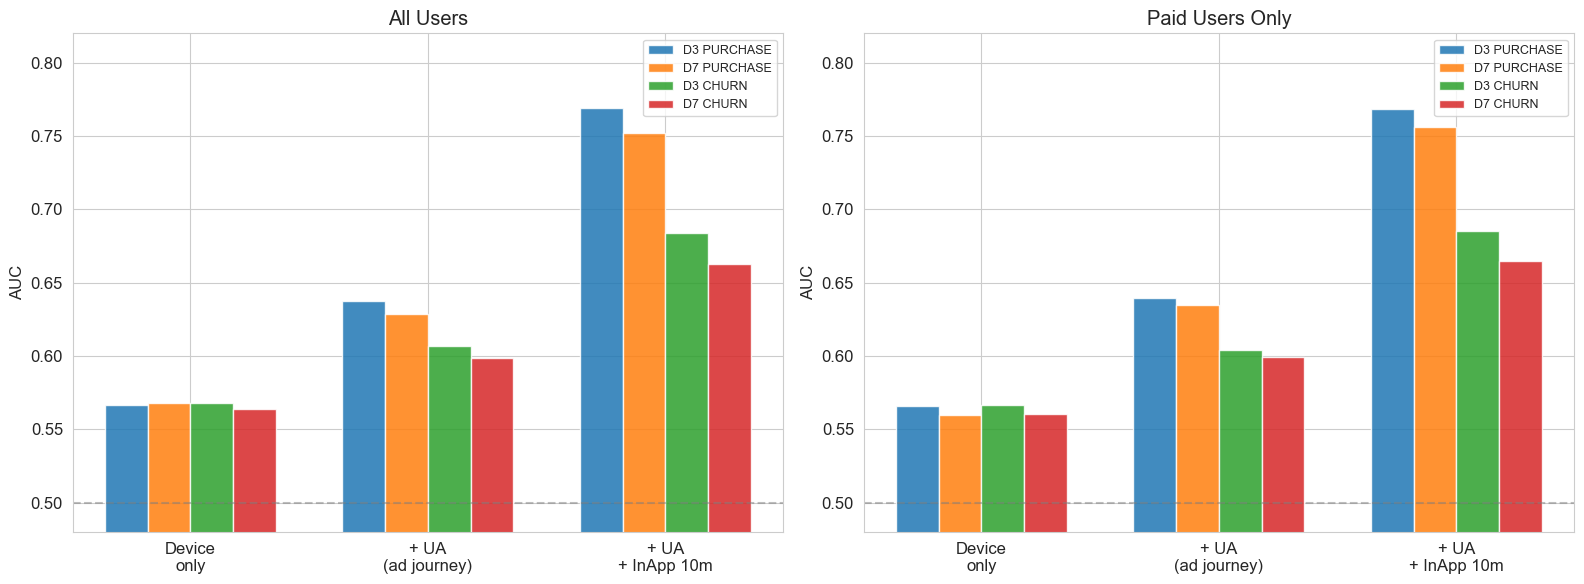

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (title, results) in enumerate([
    ('All Users', results_all), ('Paid Users Only', results_paid)
]):
    ax = axes[idx]
    labels = ['Device\nonly', '+ UA\n(ad journey)', '+ UA\n+ InApp 10m']
    model_keys = [
        'A: Device only (baseline)',
        'B: Device + UA (ad journey)',
        'C: Device + UA + InApp 10min'
    ]
    x = np.arange(len(labels))
    width = 0.18
    
    for i, target in enumerate(targets):
        vals = [results[(target, k)] for k in model_keys]
        short = target.replace('IS_', '').replace('_', ' ')
        ax.bar(x + i*width, vals, width, label=short, alpha=0.85)
    
    ax.set_ylabel('AUC')
    ax.set_title(title)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(labels)
    ax.set_ylim(0.48, 0.82)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('incremental_value.png', dpi=150, bbox_inches='tight')
plt.show()

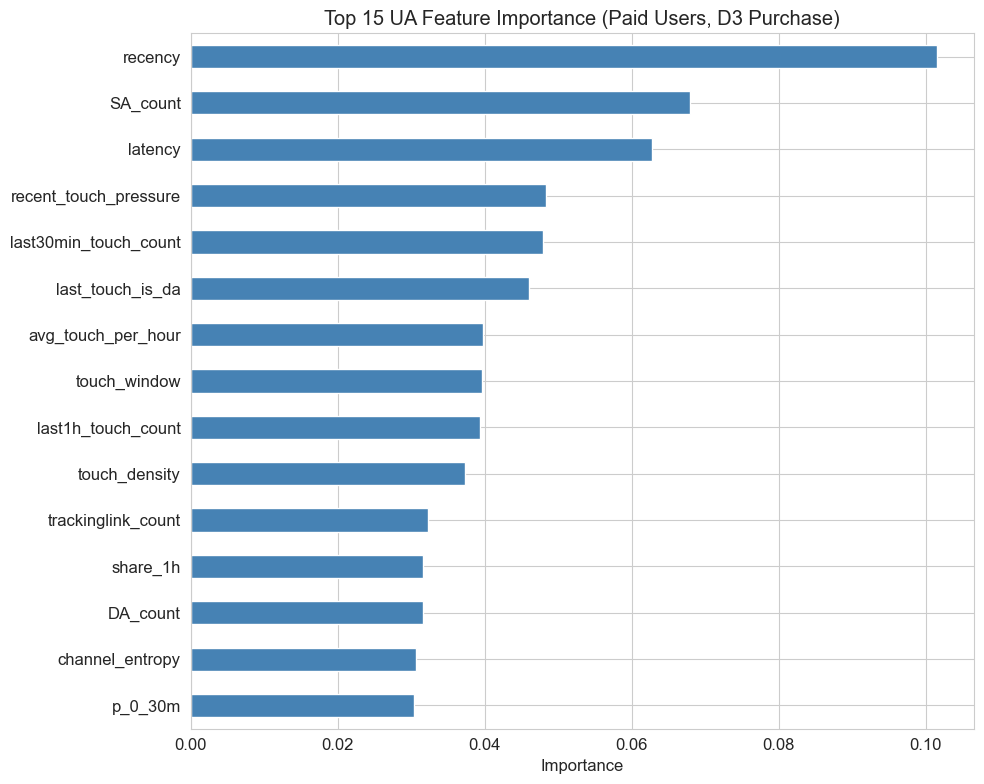

In [36]:
X = df_paid[ua_features].fillna(0)
y = df_paid['IS_D3_PURCHASE']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
rf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

importance = pd.Series(rf.feature_importances_, index=ua_features)
importance = importance.sort_values(ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 8))
importance.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 15 UA Feature Importance (Paid Users, D3 Purchase)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('ua_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [37]:
# Simulating information availability over time for paid users:
#   t=0:    Device only (true cold start, same as organic)
#   t=0:    Device + UA (cold start WITH ad journey - our proposal)
#   t=10m:  Device + InApp (early behavior, no ad journey)
#   t=10m:  Device + UA + InApp (full information)

timeline = {
    't=0  | Device only (true cold start)':   device_features,
    't=0  | Device + UA (ad journey bridge)': device_features + ua_features,
    't=10m| Device + InApp (no UA)':          device_features + inapp_features,
    't=10m| Device + UA + InApp (full)':      device_features + ua_features + inapp_features,
}

print("=" * 75)
print("COLD START TIMELINE - Paid Users")
print("=" * 75)
print(f"{'Stage':<45} {'D3_PUR':>7} {'D7_PUR':>7} {'D3_CHN':>7} {'D7_CHN':>7}")
print("-" * 75)

timeline_results = {}

for name, features in timeline.items():
    aucs = []
    for target in targets:
        X = df_paid[features].fillna(0)
        y = df_paid[target]
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        rf = RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
        )
        rf.fit(X_tr, y_tr)
        auc = roc_auc_score(y_te, rf.predict_proba(X_te)[:, 1])
        aucs.append(auc)
        timeline_results[(name, target)] = auc
    print(f"{name:<45} {aucs[0]:>7.4f} {aucs[1]:>7.4f} {aucs[2]:>7.4f} {aucs[3]:>7.4f}")

COLD START TIMELINE - Paid Users
Stage                                          D3_PUR  D7_PUR  D3_CHN  D7_CHN
---------------------------------------------------------------------------
t=0  | Device only (true cold start)           0.5659  0.5598  0.5662  0.5601
t=0  | Device + UA (ad journey bridge)         0.6392  0.6344  0.6043  0.5991
t=10m| Device + InApp (no UA)                  0.7595  0.7458  0.6774  0.6569
t=10m| Device + UA + InApp (full)              0.7684  0.7564  0.6854  0.6647


In [38]:
print("\n" + "=" * 75)
print("INCREMENTAL VALUE OF AD JOURNEY (D3 Purchase, Paid Users)")
print("=" * 75)

auc_device = timeline_results[('t=0  | Device only (true cold start)', 'IS_D3_PURCHASE')]
auc_device_ua = timeline_results[('t=0  | Device + UA (ad journey bridge)', 'IS_D3_PURCHASE')]
auc_device_inapp = timeline_results[('t=10m| Device + InApp (no UA)', 'IS_D3_PURCHASE')]
auc_full = timeline_results[('t=10m| Device + UA + InApp (full)', 'IS_D3_PURCHASE')]

print(f"  UA value at t=0 (cold start):    +{auc_device_ua - auc_device:.4f}  ({auc_device:.4f} -> {auc_device_ua:.4f})")
print(f"  UA value at t=10m (with InApp):   +{auc_full - auc_device_inapp:.4f}  ({auc_device_inapp:.4f} -> {auc_full:.4f})")
print(f"  InApp value over UA alone:        +{auc_full - auc_device_ua:.4f}  ({auc_device_ua:.4f} -> {auc_full:.4f})")
print(f"")
print(f"  => At t=0, UA provides +{auc_device_ua - auc_device:.4f} AUC lift (bridge role)")
print(f"  => At t=10m, UA still adds +{auc_full - auc_device_inapp:.4f} on top of InApp")
print(f"  => UA value diminishes: +{auc_device_ua - auc_device:.4f} -> +{auc_full - auc_device_inapp:.4f}")


INCREMENTAL VALUE OF AD JOURNEY (D3 Purchase, Paid Users)
  UA value at t=0 (cold start):    +0.0733  (0.5659 -> 0.6392)
  UA value at t=10m (with InApp):   +0.0089  (0.7595 -> 0.7684)
  InApp value over UA alone:        +0.1292  (0.6392 -> 0.7684)

  => At t=0, UA provides +0.0733 AUC lift (bridge role)
  => At t=10m, UA still adds +0.0089 on top of InApp
  => UA value diminishes: +0.0733 -> +0.0089


In [39]:
df_organic = df[df['has_touchpoint'] == 0].copy()

# Organic: Device + InApp only (best they can do at t=10m)
org_aucs = {}
for target in targets:
    X = df_organic[device_features + inapp_features].fillna(0)
    y = df_organic[target]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    org_aucs[target] = roc_auc_score(y_te, rf.predict_proba(X_te)[:, 1])

print("=" * 70)
print("PAID vs ORGANIC at t=10min")
print("=" * 70)
print(f"{'Target':<20} {'Paid (full)':>12} {'Organic':>12} {'Gap':>8}")
print("-" * 55)
for target in targets:
    paid_auc = timeline_results[('t=10m| Device + UA + InApp (full)', target)]
    org_auc = org_aucs[target]
    gap = paid_auc - org_auc
    short = target.replace('IS_', '').replace('_', ' ')
    print(f"{short:<20} {paid_auc:>12.4f} {org_auc:>12.4f} {gap:>+8.4f}")

PAID vs ORGANIC at t=10min
Target                Paid (full)      Organic      Gap
-------------------------------------------------------
D3 PURCHASE                0.7684       0.7646  +0.0038
D7 PURCHASE                0.7564       0.7486  +0.0078
D3 CHURN                   0.6854       0.6611  +0.0243
D7 CHURN                   0.6647       0.6621  +0.0026


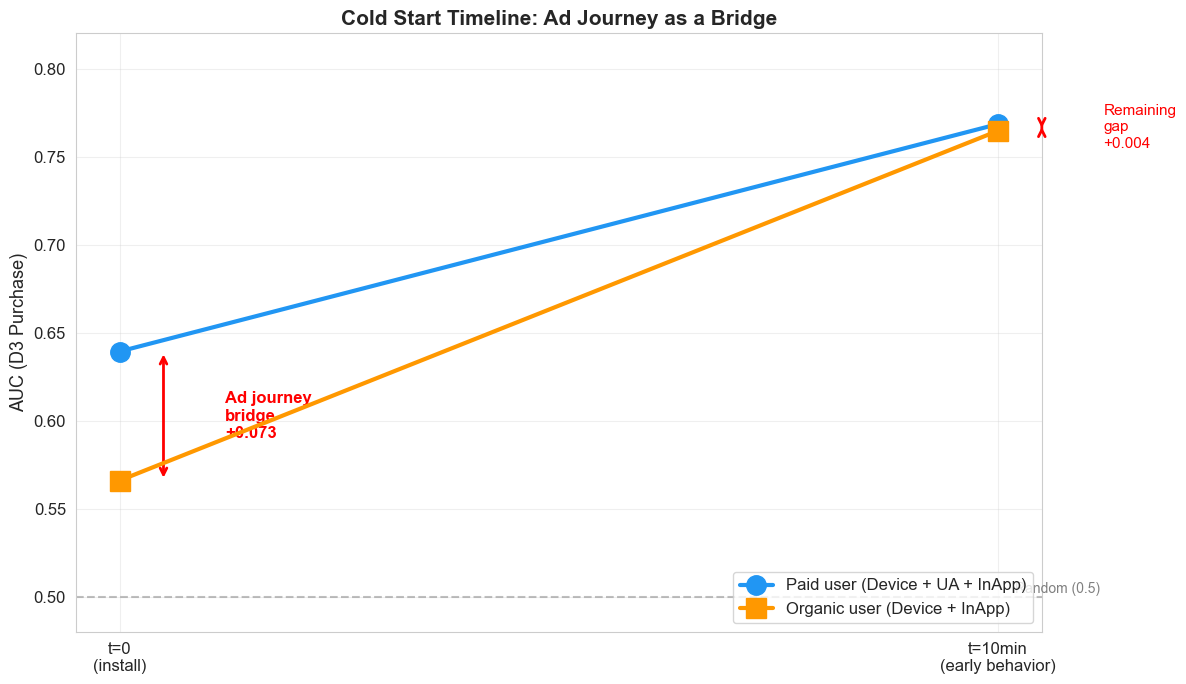


=== KEY FINDINGS ===
  At t=0:   Ad journey provides +0.0733 AUC over device-only baseline
  At t=10m: Paid still outperforms organic by +0.0038
  => Ad journey serves as a bridge until in-app data accumulates


In [40]:
fig, ax = plt.subplots(figsize=(12, 7))

# Paid user timeline
paid_t0_device = timeline_results[('t=0  | Device only (true cold start)', 'IS_D3_PURCHASE')]
paid_t0_ua = timeline_results[('t=0  | Device + UA (ad journey bridge)', 'IS_D3_PURCHASE')]
paid_t10 = timeline_results[('t=10m| Device + UA + InApp (full)', 'IS_D3_PURCHASE')]

# Organic user timeline
org_t0 = paid_t0_device  # same device info
org_t10 = org_aucs['IS_D3_PURCHASE']

stages = ['t=0\n(install)', 't=10min\n(early behavior)']

ax.plot(stages, [paid_t0_ua, paid_t10], 'o-', color='#2196F3', linewidth=3,
        markersize=14, label='Paid user (Device + UA + InApp)', zorder=5)
ax.plot(stages, [org_t0, org_t10], 's-', color='#FF9800', linewidth=3,
        markersize=14, label='Organic user (Device + InApp)', zorder=5)

# Random baseline
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.text(1.02, 0.502, 'Random (0.5)', color='gray', fontsize=10)

# Annotate bridge gap at t=0
gap_t0 = paid_t0_ua - org_t0
mid_y = (paid_t0_ua + org_t0) / 2
ax.annotate('', xy=(0.05, paid_t0_ua), xytext=(0.05, org_t0),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(0.12, mid_y, f'Ad journey\nbridge\n+{gap_t0:.3f}', fontsize=12,
        color='red', fontweight='bold', va='center')

# Annotate remaining gap at t=10m
gap_t10 = paid_t10 - org_t10
mid_y2 = (paid_t10 + org_t10) / 2
ax.annotate('', xy=(1.05, paid_t10), xytext=(1.05, org_t10),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(1.12, mid_y2, f'Remaining\ngap\n+{gap_t10:.3f}', fontsize=11,
        color='red', va='center')

ax.set_ylabel('AUC (D3 Purchase)', fontsize=13)
ax.set_title('Cold Start Timeline: Ad Journey as a Bridge', fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='lower right')
ax.set_ylim(0.48, 0.82)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cold_start_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== KEY FINDINGS ===")
print(f"  At t=0:   Ad journey provides +{gap_t0:.4f} AUC over device-only baseline")
print(f"  At t=10m: Paid still outperforms organic by +{gap_t10:.4f}")
print(f"  => Ad journey serves as a bridge until in-app data accumulates")